In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn-whitegrid')
import pandas as pd

In [3]:
directory = 'experiments-random512_01:13:03_2022-11-07'
TYPE = directory.split('_')[0].split('-')[1]

if TYPE == 'random512':
    TYPE = 'random-512'

def get_files(path):
    from os import listdir
    from os.path import isfile, join
    return [f for f in listdir(path) if isfile(join(path, f))]

def isPowerOfTwo(x):
    return (x and (not(x & (x - 1))) )
 
def collect_types(files):
    import datetime

    def parse(s, format):
        return datetime.datetime.strptime(s, format)

    types = {}
    for file in files:
        type, _, l, pattern = file.replace('.out', '').split('-')

        assert len(pattern) == int(l)
        assert isPowerOfTwo(int(l)) and isPowerOfTwo(len(pattern))

        key = f'{type}_{l}'
        if key not in types:
            types[key] = []
        types[key].append(file)
    return types

def parse_file(file):
    with open(file, 'r') as f:
        d = []
        for line in f.readlines():
            if 'Approach' in line:
                continue
            if 'Total' in line:
                d.append(['total', int(line.split(':')[1].strip().split(' ')[0])])
                continue
        return d

def transform(approach):
    if approach == "standard":
        return "Baseline"
    elif approach == "faster":
        return "Ours"
    print(approach)
    assert 0

def collect_query_data(directory):
    types = collect_types(get_files(directory))
    ds = []

    # Iterate the types: {approach}_{length}
    for type in types:
        approach, length = type.split('_')
        assert len(types[type]) == 10

        def merge(a, b):
            if a is None:
                return b 
            if b is None:
                return a
            assert len(a) == len(b)
            for index in range(len(a)):
                a[index][1] += b[index][1]
            return a

        def normalize(x, k):
            for index in range(len(x)):
                x[index][1] /= k

        local_ret = None
        for file in types[type]:
            curr_file = f'{directory}/{file}'
            curr_content = parse_file(curr_file)
            # print(f'curr_content={curr_content}')
            local_ret = merge(local_ret, curr_content)
        normalize(local_ret, len(types[type]))

        ds.append({
            'approach' : transform(approach),
            'length' : int(length),
            'time' : local_ret[0][1]
        })
    return ds

my_dir = directory
ds1 = collect_query_data(my_dir)

data = pd.DataFrame(ds1)
data.rename(columns = {'time' : 'time (ms)'}, inplace = True)
data

,approach,length,time (ms)
0,Baseline,64,384.8
1,Ours,32,694.3
2,Baseline,32,783.6
3,Ours,64,386.0
4,Ours,4,798.2
5,Baseline,8,957.2
6,Baseline,16,922.7
7,Ours,16,694.8
8,Baseline,4,983.1
9,Ours,8,706.8


In [4]:
markers = ["o", "o", "o", "s", "s", "s", "P", "P", "P", "<", "<", "<"]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:olive", "tab:red", "tab:purple", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]

all = set()
for dr in data:
    all |= set(data["approach"].unique())

print(all)

setup = {}
count = 0
for elem in sorted(list(all)):
    setup[elem] = {"color" : colors[count], "marker" : markers[count]}
    count += 1
print(setup)

{'Ours', 'Baseline'}
{'Baseline': {'color': 'tab:blue', 'marker': 'o'}, 'Ours': {'color': 'tab:orange', 'marker': 'o'}}


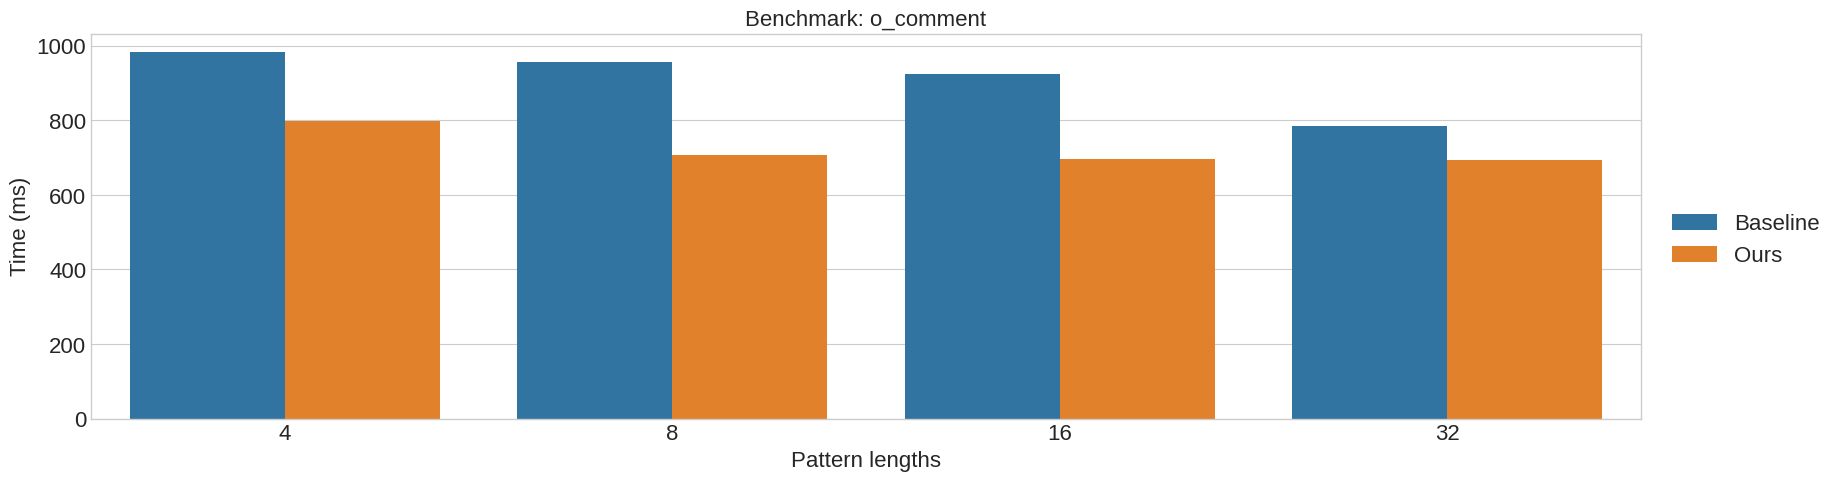

In [9]:
import seaborn as sns
from matplotlib import colors

result = ["Baseline", "Ours"]
mycolors = [setup[algo]["color"] for algo in result]
customPalette = sns.set_palette(sns.color_palette(mycolors))
lengths = sorted([int(x) for x in list(data["length"].unique())])

SINGLE_PLOT = True

data.sort_values('length')
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5 * len(lengths) - 5, 5), sharey=True, constrained_layout=False)
if SINGLE_PLOT:
    df = data.loc[data["length"] <= 32]
    sns.barplot(ax=axs, x='length', y='time (ms)', hue='approach', data=df, ci=None, hue_order=result, palette=customPalette)
else:
    for index in range(len(lengths)):
        df = data.loc[data["length"] == str(lengths[index])]
        sns.barplot(ax=axs[index], x="length", y="time (ms)", hue="approach", data=df, ci=None, hue_order=result, palette=customPalette)
    
# Build the legend
legDict = dict()
if not SINGLE_PLOT:
    for index, ax in enumerate(axs.flat):
        ax.set_title(label=f'Pattern length: {lengths[index]}', size=16)
        if index:
            # ax.set(xlabel=r'Approach')
            ax.yaxis.label.set_visible(False)
        else:
            ax.set(ylabel="Time (ms)")

        ax.set(xticklabels=[])
        ax.set(xlabel=None)
        handles, labels = ax.get_legend_handles_labels()
        ax.get_legend().set_visible(False)
        for i, label in enumerate(labels):
            if not (label in legDict):
                legDict[label] = handles[i]
else:
    # import matplotlib as mpl
    # import matplotlib as mpl
    # mpl.rcParams['text.usetex'] = True
    axs.set_title(label=f'Benchmark: {TYPE}', size=16)
    axs.set(xlabel=f'Pattern lengths', ylabel="Time (ms)")
    handles, labels = axs.get_legend_handles_labels()
    # print(labels)
    axs.get_legend().set_visible(False)
    for index, label in enumerate(labels):
        if not (label in legDict):
            legDict[label] = handles[index]

plt.rcParams['axes.labelsize'] = 16
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)  
labels = list(legDict.keys())
handles = list(legDict.values())

# Add smal spacing around legend box
fig.legend(handles=handles, labels=labels, loc="center right", borderaxespad=0.5, fontsize=16)
if TYPE == 'o_comment':
    plt.subplots_adjust(right=0.9)
else:
    plt.subplots_adjust(right=0.8)
plt.savefig(f'figures/plot-{TYPE}.png', dpi=300)